In [1]:
#Import scikit-learn dataset library
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import seaborn as sns

TESTSIZE = 0.5
KERNEL = 'linear'
from IPython.display import Audio
sound_file = 'C:/Users/annik/Downloads/beep.wav'
import time

start = time.time()

In [2]:
#add Papierdata to dataset
import json

save_name = 'dataset_WT_rot_c'
with open('../datasets/'+save_name+'.txt') as f:
    printer_dataset_dict = json.load(f)

from collections import defaultdict

dataset = {
    'data': [], #feature vectors
    'target': [], #printer-class-id (size = data-size)
    'target_names': [], #printer-class-names
    'feature_names':[], #names of the features
    'crop': [], #from which crop is the segment
    'colorbands': ['cmyk_im','c_im','m_im','y_im'],
    #'colorbands': ['cmyk_im'],
    'filename': [] #where dataset-csv is saved
}

dataset = printer_dataset_dict



In [3]:
# fix columns  for wavelet

if True:
    feature_names=['entropy','no_zero_crossings','no_mean_crossings','n5','n25','n75','n95','median','mean','std','var','rms']
    colorbands = dataset['colorbands']
    levels = 3
    ftnames = []
    for c in colorbands:
        for i in range(1,levels+2): 
            for fn in feature_names:
                if i == 1:
                    lev = "_%s" % "A"
                else:
                    lev = "_%s" % str(i-1)
                ftnames.append(c+"_"+fn+lev)
    dataset['feature_names'] = ftnames

In [4]:
targets = dataset["target_names"]

In [5]:
print(len(dataset["data"]))
print(len(dataset["crop"]))
print(len(dataset["target"]))
print(len(dataset["feature_names"]))

14528
14528
14528
192


In [6]:
# check the correlations of data of HP_PSC2175 and Canon_MX725
if False:
    ds_question = {
        'data': [], #feature vectors
        'target': [], #printer-class-id (size = data-size)
        'target_names':['HP_PSC2175', 'Canon_MX725'],
    }

    ds_question = {
        'data': [], #feature vectors
        'target': [], #printer-class-id (size = data-size)
        'target_names':['HP_PSC2175', 'Canon_MX725'],
    }


    for i, tgt in enumerate(dataset['target']):
        tn = dataset['target_names'][tgt]
        data = dataset['data'][i]
        dat = []
        if tn == 'HP_PSC2175' or tn == 'Canon_MX725':
            for j, fn in enumerate(dataset["feature_names"]):
                if fn in ["cmyk_im_var_2", "cmyk_im_var_4", "cmyk_im_std_4", "cmyk_im_var_3", "cmyk_im_n25_4", "cmyk_im_std_3"]:
                    dat.append(data[j])
        if tn == 'HP_PSC2175':
            ds_question['target'].append(0)
            ds_question['data'].append(dat)
        if tn == 'Canon_MX725':
            ds_question['target'].append(1)
            ds_question['data'].append(dat)


    dataset_q_df = pd.DataFrame(ds_question["data"], columns=["cmyk_im_var_2", "cmyk_im_var_4", "cmyk_im_std_4", "cmyk_im_var_3", "cmyk_im_n25_4", "cmyk_im_std_3"])
    display(dataset_q_df)


    corr = dataset_q_df.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    

In [7]:
#ohne farbenteilung 
#dataset["feature_names"] = ['entropy','no_zero_crossings','no_mean_crossings','n5','n25','n75','n95','median','mean','std','var','rms']

dataset_df = pd.DataFrame(dataset["data"], columns=dataset['feature_names'])
dataset_df.head(4)

,cmyk_im_entropy_A,cmyk_im_no_zero_crossings_A,cmyk_im_no_mean_crossings_A,cmyk_im_n5_A,cmyk_im_n25_A,cmyk_im_n75_A,cmyk_im_n95_A,cmyk_im_median_A,cmyk_im_mean_A,cmyk_im_std_A,...,y_im_no_mean_crossings_3,y_im_n5_3,y_im_n25_3,y_im_n75_3,y_im_n95_3,y_im_median_3,y_im_mean_3,y_im_std_3,y_im_var_3,y_im_rms_3
0,9.208739,0.0,508.0,23.125338,42.211029,333.321322,366.943838,132.020939,187.383817,143.884544,...,19642.0,-6.468944,-2.295591,2.266598,6.507844,-0.011191,-0.000718,3.951677,15.615751,2.974211
1,9.208739,8.0,534.0,22.353454,39.963565,189.136220,209.234945,102.785919,115.804626,75.020682,...,19920.0,-6.771289,-2.388929,2.279893,6.902583,-0.046157,-0.012805,4.148181,17.207409,3.093934
2,9.208739,0.0,518.0,26.160155,48.185798,554.690490,582.591463,175.736245,254.144421,230.617466,...,19473.0,-5.545366,-1.883301,1.786955,5.507256,-0.036720,-0.032003,3.421466,11.706430,2.498744
3,9.208739,6.0,950.0,23.834025,46.091692,415.450951,585.034369,206.410351,234.602562,211.193325,...,19634.0,-5.856028,-2.000331,1.898580,5.925188,-0.047246,-0.024097,3.621864,13.117898,2.648781


In [8]:
print("Shape of Dataframe:", dataset_df.shape)
print("Features:", dataset_df.columns)

Shape of Dataframe: (14528, 192)
Features: Index(['cmyk_im_entropy_A', 'cmyk_im_no_zero_crossings_A',
       'cmyk_im_no_mean_crossings_A', 'cmyk_im_n5_A', 'cmyk_im_n25_A',
       'cmyk_im_n75_A', 'cmyk_im_n95_A', 'cmyk_im_median_A', 'cmyk_im_mean_A',
       'cmyk_im_std_A',
       ...
       'y_im_no_mean_crossings_3', 'y_im_n5_3', 'y_im_n25_3', 'y_im_n75_3',
       'y_im_n95_3', 'y_im_median_3', 'y_im_mean_3', 'y_im_std_3',
       'y_im_var_3', 'y_im_rms_3'],
      dtype='object', length=192)


['cmyk_im_entropy_A', 'cmyk_im_no_zero_crossings_A', 'cmyk_im_no_mean_crossings_A', 'cmyk_im_n5_A', 'cmyk_im_n25_A', 'cmyk_im_n75_A', 'cmyk_im_n95_A', 'cmyk_im_median_A', 'cmyk_im_mean_A', 'cmyk_im_std_A', 'cmyk_im_var_A', 'cmyk_im_rms_A']


,cmyk_im_entropy_A,cmyk_im_no_zero_crossings_A,cmyk_im_no_mean_crossings_A,cmyk_im_n5_A,cmyk_im_n25_A,cmyk_im_n75_A,cmyk_im_n95_A,cmyk_im_median_A,cmyk_im_mean_A,cmyk_im_std_A,cmyk_im_var_A,cmyk_im_rms_A
0,9.208739,0.0,508.0,23.125338,42.211029,333.321322,366.943838,132.020939,187.383817,143.884544,20702.761984,187.383817
1,9.208739,8.0,534.0,22.353454,39.963565,189.136220,209.234945,102.785919,115.804626,75.020682,5628.102730,115.808497
2,9.208739,0.0,518.0,26.160155,48.185798,554.690490,582.591463,175.736245,254.144421,230.617466,53184.415673,254.144421
3,9.208739,6.0,950.0,23.834025,46.091692,415.450951,585.034369,206.410351,234.602562,211.193325,44602.620615,234.603113
4,9.208739,4.0,534.0,19.238241,37.348688,246.461539,287.586872,85.183424,138.500561,105.186749,11064.252144,138.502398
...,...,...,...,...,...,...,...,...,...,...,...,...
14523,9.208739,0.0,2903.0,393.579320,510.163414,557.340450,583.673976,534.785925,523.915823,55.900224,3124.835079,523.915823
14524,9.208739,0.0,734.0,20.241687,36.958785,193.624698,431.076201,87.877591,138.217483,131.354680,17254.051989,138.217483
14525,9.208739,0.0,783.0,18.539054,72.985127,369.547461,467.337240,218.224995,225.056745,157.071982,24671.607390,225.056745
14526,9.208739,0.0,624.0,26.356186,101.147695,484.625920,563.789939,409.810404,339.003935,191.326111,36605.680566,339.003935


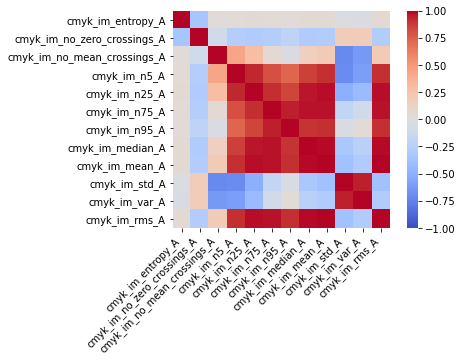

In [9]:
#select all mean features and plot correlation
feature_cmyk = list(dataset_df.columns[0:12])
print(feature_cmyk)

feature_cmyk_df = dataset_df[feature_cmyk]
display(feature_cmyk_df)

corr = feature_cmyk_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm',
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [10]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

X_train = []
y_train = []
X_test = []
y_test = []
        
def train_test_gen(train_crops, test_crops = [7], reduce = 1):
    for idx, crop in enumerate(dataset["crop"]):
        if crop in train_crops:
            if idx%reduce == 0:#datensatz reduziert
                X_train.append(dataset["data"][idx])
                y_train.append(dataset["target"][idx])
        elif crop in test_crops:
            X_test.append(dataset["data"][idx])
            y_test.append(dataset["target"][idx])        
            
            
#Sample Data Standard (Test-Sample ist das Bild des älteren Herrn)
train_test_gen([0,1,2,3,4,5,6,8,10], [7,9])

#komplett test
#train_test_gen([],[0,1,2,3,4,5,6,8,10,7,9])

#ohne Text trainiert, Testdaten nur Text
#train_test_gen([0,3,4,5,6,8,9,10],[1,2])

#nur monoFarben trainiert, Testdaten Standard
#train_test_gen([4,8,10])
#Datensatz reduziert zum Vergleich
#train_test_gen([0,1,2,3,4,5,6,8,9,10],[7],3)

#ohne monofarben trainiert
#train_test_gen([1,2,5,6,9])

#ohne lichte monofarben trainiert
#train_test_gen([0,1,2,3,5,6,8,9])

#ohne kontrastreiche monofarben trainiert
#train_test_gen([1,2,3,5,6,9,10])

#nur Text trainiert, Testdaten Standard
#train_test_gen([1])
#Datensatz reduziert zum Vergleich
#train_test_gen([0,1,2,3,4,5,6,8,9,10],[7],5)

#ohne(weniger) schwarz
#train_test_gen([0,3,4,5,6,8,10])

#nur licht
#train_test_gen([10])

#nur kontrastreich
#train_test_gen([8])

#ohne Text trainiert, Testdaten Standard
#train_test_gen([0,3,4,5,6,8,9,10])


#Text train & Text test
#cnt1 = dataset["crop"].count(1) // 3
#cnt2 = dataset["crop"].count(2) // 3
#counter1 = 0
#counter2 = 0

#for idx, crop in enumerate(dataset["crop"]):
   # if crop == 1:
       # if counter1 < cnt1 * 2:
           # X_train.append(dataset["data"][idx])
          #  y_train.append(dataset["target"][idx])
       # else:
         #   X_test.append(dataset["data"][idx])
          #  y_test.append(dataset["target"][idx])
      #  counter1 += 1
  #  elif crop == 2:
   #     if counter2 < cnt2:
    #        X_test.append(dataset["data"][idx])
    #        y_test.append(dataset["target"][idx])
   #     else:
    #        X_train.append(dataset["data"][idx])
    #        y_train.append(dataset["target"][idx])   
  #      counter2 += 1

#licht lernen, kontrastreich testen
#train_test_gen([10],[8])

#pridentifier
#for idx, crop in enumerate(dataset["crop"]):
    #if crop%2 == 0:
        #X_test.append(dataset["data"][idx])
        #y_test.append(dataset["target"][idx])
    #else:
        #X_train.append(dataset["data"][idx])
        #y_train.append(dataset["target"][idx])
        
print(len(X_test))       
print(len(X_train)) 
# Split dataset into training set and test set --> erste anläufe, da test/train dann immer direkt nebeneinander liegen wurde davon Abstand genommen, um dies als Faktor auszuschließen
#X_train, X_test, y_train, y_test = train_test_split(dataset["data"], dataset["target"], test_size=TESTSIZE,random_state=30)


    

5308
9220


In [11]:
dataset["target_names"] = targets

46


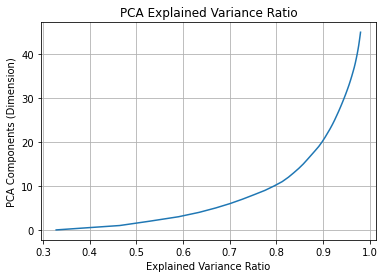

In [12]:
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

filename = '../datasets/'+save_name+'.sav'

if True: 
    #SVM
    clf = Pipeline(steps=[('ssc',StandardScaler()),('pca', PCA(n_components=0.98)), ('svm',svm.SVC(kernel='linear'))])
    #clf = Pipeline(steps=[('ssc',StandardScaler()), ('svm',svm.SVC(kernel='linear'))])
    clf.fit(X_train, y_train)

    evr = clf.steps[1][1].explained_variance_ratio_.cumsum()
    print(len(evr))
    
    fig, ax = plt.subplots()
    ax.plot(evr, range(len(evr)))

    ax.set(xlabel='Explained Variance Ratio', ylabel='PCA Components (Dimension)',
           title='PCA Explained Variance Ratio')
    ax.grid()

    plt.show()

if False:
    pickle.dump(clf, open(filename, 'wb'))

# load the model from disk
if False: #set True if needed
    # load model from disk
    clf = pickle.load(open(filename, 'rb'))

In [13]:
# Prediction and Plotting Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import metrics

y_pred = clf.predict(X_test)

print(y_pred)

confusion = confusion_matrix(y_test, y_pred)
full_confusion = np.zeros(shape=(len(dataset["target_names"]),len(dataset["target_names"])))
for i, tgt in enumerate(dataset["target_names"]):
    for p, pr in enumerate(y_pred):
        if i == y_test[p]:
            full_confusion[i][pr] += 1


print('Confusion Matrix\n')
print(confusion)
print(full_confusion)
print(len(y_pred)/4)
#importing accuracy_score, precision_score, recall_score, f1_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

#print(classification_report(y_test, y_pred, target_names=dataset["target_names"]))

[ 0  0  0 ... 11 11 11]
Confusion Matrix

[[342  66   0   0   0   0   0   0   0   0   0   1]
 [120 289   0   0   0   0   0   0   0   0   0   0]
 [  1   0 434  10   4   0   0   0   0   0   0   0]
 [  5   0   4 435   5   0   0   0   0   0   0   0]
 [  0   0  25  17 406   0   0   0   0   1   0   0]
 [  0   1   0   0   8 440   0   0   0   0   0   0]
 [ 52   6   0  19   7   0 365   0   0   0   0   0]
 [  0   0   0   0   0   0   2 447   0   0   0   0]
 [  0   0   0   3   5   0   0   0 441   0   0   0]
 [ 24  11   0   0  15   6  59   0   0 333   0   1]
 [  0   0   0   0   0   0   0   1   0   0 448   0]
 [ 11   5   4   1   5   0   6   0   1   4   0 412]]
[[342.  66.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
 [120. 289.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   0. 434.  10.   4.   0.   0.   0.   0.   0.   0.   0.]
 [  5.   0.   4. 435.   5.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  25.  17. 406.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   1.   0.   0.   8. 440

In [14]:
end = time.time()
print(end - start)

5.561639785766602


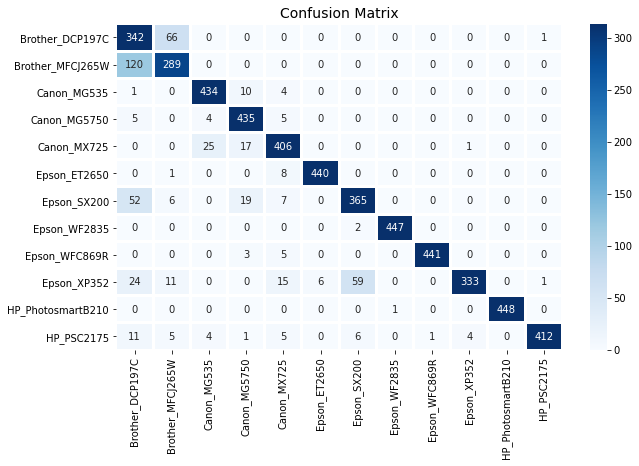

In [15]:
df_cm = pd.DataFrame(full_confusion, dataset["target_names"], dataset["target_names"])

f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_cm, vmin=df_cm.values.min(), vmax=df_cm.values.max()*0.7, square=False, 
        linewidths=2, annot=True, ax = ax, cmap='Blues', fmt='g')  
plt.title("Confusion Matrix", fontsize=14)
plt.savefig("Confusion Matrix.png", dpi=200)

In [16]:
components_df = pd.DataFrame(clf.steps[1][1].components_,columns=dataset["feature_names"])
display(components_df)

#BetragsMaxima pro Koeffizient
frames=[]
for c in components_df.iterrows():
    display(pd.DataFrame(c[1].abs().sort_values(ascending=False))[0:10])

for c in components_df.iterrows():
    frames.append(pd.DataFrame(c[1].abs().sort_values(ascending=False))[0:10].index.values)

display(pd.DataFrame(frames, columns=range(10)).T)

,cmyk_im_entropy_A,cmyk_im_no_zero_crossings_A,cmyk_im_no_mean_crossings_A,cmyk_im_n5_A,cmyk_im_n25_A,cmyk_im_n75_A,cmyk_im_n95_A,cmyk_im_median_A,cmyk_im_mean_A,cmyk_im_std_A,...,y_im_no_mean_crossings_3,y_im_n5_3,y_im_n25_3,y_im_n75_3,y_im_n95_3,y_im_median_3,y_im_mean_3,y_im_std_3,y_im_var_3,y_im_rms_3
0,0.004134,0.022713,0.010808,-0.075142,-0.077701,-0.069349,-0.064254,-0.074057,-0.075732,0.037405,...,0.060585,-0.085578,-0.089451,0.087992,0.087059,-0.049433,-0.001842,0.083957,0.071943,0.087846
1,0.008015,-0.050260,0.063196,0.137935,0.139842,0.134961,0.122277,0.138202,0.141153,-0.075953,...,0.032011,-0.058820,-0.055974,0.056524,0.060031,-0.058698,-0.000974,0.066511,0.075849,0.060806
2,-0.021092,0.005989,-0.022362,-0.032599,-0.052778,-0.057402,-0.062964,-0.056223,-0.054624,-0.011428,...,0.125915,-0.107546,-0.117564,0.115757,0.109767,-0.073012,-0.001397,0.102518,0.089546,0.111991
3,0.003345,0.011710,-0.023821,-0.021403,-0.046132,-0.062492,-0.072630,-0.056473,-0.053327,-0.041915,...,0.006843,-0.083308,-0.082056,0.084457,0.080352,0.010738,0.001377,0.085205,0.088461,0.084374
4,-0.023393,0.035739,-0.247507,-0.085200,-0.009448,0.088565,0.122788,0.046384,0.030943,0.268571,...,-0.034822,-0.055224,-0.017004,0.015865,0.053946,0.011794,-0.000262,0.056090,0.050440,0.039051
5,-0.187206,0.070817,0.022450,0.022323,0.008326,-0.008322,-0.020897,-0.002426,0.000825,-0.051532,...,-0.084001,0.006258,0.007797,-0.011092,-0.003047,-0.040867,0.003954,-0.001014,0.008417,-0.006686
6,0.061052,-0.000562,-0.017447,-0.035472,-0.046345,-0.060356,-0.063493,-0.054995,-0.053762,-0.012234,...,-0.217095,0.011876,-0.007998,0.006649,-0.010811,-0.015409,-0.000843,-0.006626,0.006067,-0.003641
7,-0.110211,0.002496,-0.008661,-0.045174,-0.048088,-0.039714,-0.029272,-0.044410,-0.044425,0.034223,...,0.024297,0.022852,0.031626,-0.023452,-0.032027,0.156225,0.009961,-0.029722,-0.019426,-0.027990
8,-0.011130,-0.004447,-0.017163,-0.022396,-0.021858,-0.022141,-0.024071,-0.022326,-0.022996,0.007286,...,0.056830,0.022877,0.019908,-0.017332,-0.025678,0.050628,0.011992,-0.026367,-0.024099,-0.022202
9,-0.023980,0.024140,0.056659,0.021943,0.015479,0.001459,0.010493,0.009168,0.011162,-0.024302,...,-0.074666,-0.059511,-0.037065,0.036560,0.059148,0.005356,-0.002437,0.064817,0.066769,0.051498


,0
cmyk_im_n75_2,0.117291
cmyk_im_rms_2,0.115994
cmyk_im_n25_2,0.115483
cmyk_im_n75_1,0.114445
cmyk_im_n25_1,0.113083
m_im_n25_2,0.110710
cmyk_im_n95_2,0.109444
cmyk_im_n5_2,0.109301
m_im_n75_2,0.108756
cmyk_im_std_2,0.108426


,1
c_im_n75_A,0.143163
c_im_rms_A,0.141631
c_im_mean_A,0.141625
cmyk_im_mean_A,0.141153
cmyk_im_rms_A,0.141151
cmyk_im_n25_A,0.139842
c_im_n95_A,0.139689
m_im_no_zero_crossings_2,0.139293
c_im_median_A,0.139137
m_im_no_mean_crossings_2,0.138544


,2
c_im_std_1,0.168014
c_im_var_1,0.163898
c_im_n95_1,0.163839
c_im_n5_1,0.162760
c_im_std_2,0.154303
c_im_rms_1,0.152975
c_im_var_2,0.149886
c_im_n95_2,0.148926
c_im_n5_2,0.145295
c_im_rms_2,0.139522


,3
m_im_var_1,0.195884
m_im_std_1,0.187541
m_im_n5_1,0.184079
m_im_n95_1,0.182475
m_im_rms_1,0.158949
c_im_n75_3,0.151125
c_im_n25_3,0.149325
c_im_rms_3,0.149202
c_im_n5_3,0.147589
m_im_no_zero_crossings_2,0.147075


,4
cmyk_im_var_A,0.269798
cmyk_im_std_A,0.268571
m_im_std_A,0.264821
m_im_var_A,0.263799
m_im_no_mean_crossings_A,0.257142
y_im_std_A,0.248185
cmyk_im_no_mean_crossings_A,0.247507
y_im_var_A,0.244752
c_im_no_mean_crossings_A,0.242176
c_im_std_A,0.215261


,5
c_im_entropy_1,0.260647
c_im_entropy_A,0.260579
c_im_entropy_2,0.254756
cmyk_im_entropy_2,0.241262
c_im_entropy_3,0.231737
m_im_entropy_3,0.215065
c_im_no_mean_crossings_1,0.211770
m_im_entropy_2,0.205760
m_im_no_zero_crossings_A,0.197739
c_im_no_zero_crossings_1,0.192244


,6
y_im_entropy_2,0.311061
y_im_entropy_1,0.304564
y_im_entropy_A,0.304563
y_im_entropy_3,0.288582
y_im_no_mean_crossings_1,0.287376
y_im_no_zero_crossings_1,0.280966
y_im_no_mean_crossings_3,0.217095
y_im_no_zero_crossings_3,0.215884
y_im_no_zero_crossings_A,0.151081
y_im_no_mean_crossings_2,0.125970


,7
y_im_var_1,0.188492
y_im_std_1,0.171854
y_im_n5_1,0.166536
y_im_n95_1,0.164072
y_im_var_2,0.160321
y_im_rms_1,0.159783
y_im_median_3,0.156225
y_im_n25_1,0.148388
y_im_std_2,0.144665
y_im_n5_2,0.141022


,8
cmyk_im_mean_1,0.363593
cmyk_im_median_1,0.342718
m_im_mean_1,0.337907
m_im_median_1,0.312233
y_im_mean_1,0.241187
c_im_mean_1,0.232549
y_im_median_1,0.230144
c_im_median_1,0.195663
cmyk_im_mean_2,0.162999
cmyk_im_median_2,0.159984


,9
cmyk_im_no_zero_crossings_1,0.299970
cmyk_im_no_mean_crossings_1,0.298792
m_im_no_zero_crossings_1,0.283096
m_im_no_mean_crossings_1,0.279875
cmyk_im_median_1,0.199537
cmyk_im_median_2,0.191455
cmyk_im_mean_1,0.187317
m_im_median_2,0.186221
m_im_median_1,0.185276
c_im_no_zero_crossings_1,0.180328


,10
cmyk_im_mean_2,0.400905
m_im_mean_2,0.371330
cmyk_im_median_2,0.345718
m_im_median_2,0.330346
c_im_mean_2,0.273477
c_im_median_2,0.210040
cmyk_im_no_mean_crossings_1,0.179429
cmyk_im_no_zero_crossings_1,0.177169
m_im_no_zero_crossings_1,0.160897
m_im_no_mean_crossings_1,0.154502


,11
m_im_entropy_1,0.357971
m_im_entropy_A,0.357735
m_im_entropy_2,0.325279
m_im_entropy_3,0.267369
c_im_entropy_2,0.262883
c_im_entropy_3,0.232628
c_im_entropy_A,0.228836
c_im_entropy_1,0.228287
c_im_no_zero_crossings_3,0.178723
c_im_no_mean_crossings_3,0.178102


,12
m_im_no_zero_crossings_3,0.289411
m_im_no_mean_crossings_3,0.287539
cmyk_im_no_mean_crossings_3,0.240176
cmyk_im_no_zero_crossings_3,0.239102
c_im_no_zero_crossings_3,0.223752
c_im_no_mean_crossings_3,0.220495
y_im_std_3,0.169962
y_im_var_3,0.166073
y_im_n5_3,0.161201
y_im_n95_3,0.151333


,13
cmyk_im_mean_3,0.555622
m_im_mean_3,0.496926
cmyk_im_median_3,0.334110
m_im_median_3,0.313953
c_im_median_3,0.221618
c_im_mean_3,0.171666
cmyk_im_no_zero_crossings_A,0.109244
c_im_var_A,0.086420
y_im_n75_3,0.081957
y_im_n25_3,0.079230


,14
y_im_var_3,0.262917
y_im_no_zero_crossings_2,0.203395
y_im_n75_3,0.202130
y_im_no_zero_crossings_3,0.197217
y_im_no_mean_crossings_2,0.195789
y_im_no_mean_crossings_3,0.194426
m_im_mean_3,0.188066
cmyk_im_mean_3,0.186145
y_im_n25_3,0.185388
y_im_n5_3,0.184864


,15
cmyk_im_entropy_1,0.502080
cmyk_im_entropy_A,0.499315
cmyk_im_entropy_2,0.343032
m_im_entropy_A,0.267911
m_im_entropy_1,0.265588
m_im_entropy_2,0.225798
m_im_entropy_3,0.189496
c_im_no_zero_crossings_A,0.147069
c_im_entropy_3,0.121012
cmyk_im_no_zero_crossings_A,0.098227


,16
y_im_mean_2,0.395663
y_im_median_2,0.341566
c_im_median_2,0.291793
c_im_mean_2,0.280615
c_im_n5_A,0.169111
c_im_n25_A,0.167963
m_im_mean_3,0.163516
c_im_var_A,0.150674
cmyk_im_mean_3,0.147339
y_im_n5_A,0.129411


,17
c_im_median_1,0.404995
c_im_mean_1,0.380357
y_im_mean_1,0.359902
y_im_median_1,0.359034
c_im_median_3,0.231517
y_im_median_3,0.170301
m_im_mean_3,0.150663
c_im_n5_A,0.117669
cmyk_im_median_3,0.117150
m_im_entropy_A,0.105408


,18
c_im_median_3,0.348012
m_im_mean_3,0.314069
y_im_mean_1,0.276833
y_im_median_1,0.268683
c_im_mean_1,0.255233
cmyk_im_mean_3,0.254156
c_im_median_1,0.227307
y_im_median_2,0.200553
cmyk_im_no_zero_crossings_A,0.192546
cmyk_im_median_3,0.177356


,19
y_im_mean_2,0.417503
c_im_median_2,0.307265
c_im_mean_2,0.307225
y_im_median_2,0.278241
c_im_n5_A,0.172052
c_im_median_1,0.170137
c_im_n25_A,0.164973
c_im_mean_1,0.158382
y_im_mean_1,0.149066
y_im_median_1,0.134654


,20
c_im_mean_3,0.409132
cmyk_im_entropy_3,0.375542
m_im_no_zero_crossings_A,0.307035
c_im_median_3,0.263879
c_im_no_zero_crossings_A,0.217972
m_im_entropy_A,0.203954
m_im_entropy_1,0.202820
m_im_mean_3,0.185151
y_im_no_zero_crossings_A,0.168962
cmyk_im_no_mean_crossings_A,0.165589


,21
c_im_mean_3,0.669671
y_im_mean_3,0.327391
cmyk_im_entropy_3,0.213104
y_im_median_3,0.206820
m_im_median_3,0.179151
c_im_median_3,0.154134
m_im_no_zero_crossings_A,0.146473
cmyk_im_no_zero_crossings_A,0.140154
cmyk_im_mean_3,0.139720
m_im_mean_3,0.131069


,22
y_im_mean_3,0.645588
cmyk_im_no_zero_crossings_A,0.429409
c_im_var_A,0.191893
cmyk_im_no_mean_crossings_A,0.159591
c_im_mean_3,0.152412
cmyk_im_mean_3,0.143162
y_im_median_3,0.133766
m_im_no_zero_crossings_A,0.131450
c_im_std_A,0.118654
m_im_no_mean_crossings_A,0.114475


,23
y_im_mean_3,0.488725
c_im_var_A,0.288438
cmyk_im_no_zero_crossings_A,0.245908
c_im_std_A,0.214470
y_im_std_A,0.171266
c_im_mean_3,0.161579
y_im_var_A,0.160919
m_im_mean_3,0.152154
m_im_no_zero_crossings_A,0.142478
c_im_n25_3,0.138856


,24
cmyk_im_no_zero_crossings_A,0.372148
c_im_median_2,0.318396
y_im_median_2,0.295661
y_im_mean_3,0.283732
m_im_mean_2,0.260417
y_im_var_A,0.209482
cmyk_im_mean_2,0.165944
m_im_median_3,0.161353
m_im_entropy_3,0.159705
cmyk_im_entropy_3,0.159173


,25
c_im_median_2,0.352029
y_im_median_2,0.321663
m_im_mean_2,0.240921
y_im_mean_2,0.239945
m_im_no_mean_crossings_A,0.238083
c_im_mean_2,0.233570
cmyk_im_no_mean_crossings_A,0.231364
y_im_var_A,0.214365
m_im_median_2,0.197731
c_im_no_mean_crossings_A,0.183106


,26
m_im_median_3,0.328140
m_im_median_2,0.288419
c_im_mean_2,0.275982
y_im_mean_2,0.260689
cmyk_im_no_zero_crossings_A,0.222486
cmyk_im_median_3,0.214194
c_im_no_mean_crossings_A,0.211406
m_im_no_mean_crossings_A,0.209024
cmyk_im_median_2,0.176024
cmyk_im_var_A,0.170404


,27
y_im_no_zero_crossings_1,0.327640
c_im_var_A,0.279027
y_im_no_mean_crossings_1,0.268764
y_im_no_zero_crossings_A,0.239655
c_im_std_A,0.221114
c_im_no_zero_crossings_A,0.220209
c_im_median_3,0.164152
c_im_no_mean_crossings_A,0.159506
cmyk_im_median_3,0.152454
m_im_median_3,0.151696


,28
cmyk_im_no_mean_crossings_A,0.280193
m_im_no_zero_crossings_A,0.258574
c_im_var_A,0.253528
c_im_no_zero_crossings_A,0.225818
c_im_std_A,0.225105
m_im_no_mean_crossings_A,0.193084
y_im_no_zero_crossings_1,0.188629
y_im_no_mean_crossings_1,0.173460
c_im_n95_A,0.168390
cmyk_im_entropy_3,0.149025


,29
m_im_median_1,0.419172
c_im_median_1,0.396037
m_im_mean_1,0.371505
y_im_median_1,0.370092
y_im_mean_1,0.366142
c_im_mean_1,0.307405
cmyk_im_median_1,0.130125
m_im_no_zero_crossings_A,0.099463
c_im_no_zero_crossings_1,0.086423
cmyk_im_mean_1,0.083048


,30
c_im_median_3,0.310667
c_im_mean_3,0.235777
c_im_entropy_1,0.188857
c_im_entropy_A,0.188031
y_im_no_zero_crossings_A,0.181579
c_im_mean_2,0.180384
c_im_no_mean_crossings_1,0.171164
cmyk_im_no_zero_crossings_A,0.166224
c_im_no_zero_crossings_1,0.164662
m_im_no_mean_crossings_1,0.160455


,31
y_im_no_zero_crossings_A,0.432475
cmyk_im_var_A,0.224080
m_im_var_A,0.224031
y_im_no_mean_crossings_A,0.214168
y_im_mean_2,0.201114
m_im_no_zero_crossings_A,0.199352
c_im_no_zero_crossings_A,0.187731
y_im_std_A,0.165852
c_im_no_mean_crossings_A,0.165008
y_im_entropy_3,0.161435


,32
c_im_no_zero_crossings_A,0.558599
y_im_no_zero_crossings_A,0.270357
cmyk_im_entropy_3,0.212223
c_im_no_zero_crossings_1,0.201606
c_im_entropy_3,0.193139
cmyk_im_no_mean_crossings_A,0.182121
m_im_entropy_3,0.141060
c_im_no_mean_crossings_1,0.140669
m_im_mean_1,0.116807
c_im_entropy_A,0.116104


,33
m_im_median_1,0.308479
cmyk_im_median_1,0.300376
cmyk_im_mean_1,0.284715
c_im_mean_1,0.260551
m_im_mean_1,0.240263
c_im_no_zero_crossings_1,0.225093
c_im_median_1,0.221492
m_im_no_mean_crossings_1,0.178222
c_im_no_mean_crossings_1,0.173849
y_im_var_A,0.172626


,34
y_im_no_zero_crossings_A,0.410497
y_im_entropy_A,0.256532
y_im_entropy_1,0.256531
y_im_no_mean_crossings_A,0.247764
c_im_no_zero_crossings_A,0.219358
y_im_no_mean_crossings_1,0.211138
y_im_no_zero_crossings_1,0.187344
m_im_no_zero_crossings_A,0.173881
y_im_no_zero_crossings_2,0.144738
y_im_entropy_3,0.121033


,35
c_im_no_mean_crossings_1,0.307059
c_im_no_zero_crossings_1,0.303104
m_im_mean_1,0.246151
c_im_no_zero_crossings_A,0.231014
c_im_median_3,0.226159
c_im_median_1,0.209157
cmyk_im_mean_1,0.200753
y_im_no_zero_crossings_A,0.194366
cmyk_im_median_1,0.174463
m_im_no_zero_crossings_1,0.163309


,36
cmyk_im_no_zero_crossings_A,0.274190
y_im_median_3,0.239758
y_im_median_2,0.232130
y_im_mean_2,0.219108
m_im_median_2,0.207807
cmyk_im_median_2,0.199379
cmyk_im_mean_2,0.190113
m_im_mean_2,0.163553
cmyk_im_median_3,0.160718
m_im_median_3,0.157266


,37
cmyk_im_no_mean_crossings_2,0.236013
cmyk_im_no_zero_crossings_2,0.234497
cmyk_im_var_1,0.205617
m_im_no_zero_crossings_2,0.189961
m_im_no_mean_crossings_2,0.188121
y_im_no_zero_crossings_2,0.160306
y_im_no_mean_crossings_2,0.150792
m_im_no_zero_crossings_A,0.150223
c_im_no_mean_crossings_2,0.148352
m_im_var_1,0.147455


,38
y_im_mean_2,0.421994
y_im_median_2,0.373089
cmyk_im_no_zero_crossings_A,0.196089
m_im_var_2,0.164335
cmyk_im_var_2,0.161117
y_im_median_3,0.148125
m_im_mean_2,0.146088
m_im_median_3,0.132199
cmyk_im_var_3,0.131934
m_im_no_mean_crossings_A,0.126406


,39
y_im_median_3,0.284138
m_im_no_zero_crossings_A,0.245638
m_im_median_2,0.213353
c_im_median_2,0.192113
cmyk_im_median_2,0.184350
m_im_mean_2,0.176996
cmyk_im_mean_2,0.174584
c_im_median_3,0.172572
cmyk_im_entropy_3,0.170290
m_im_var_A,0.151856


,40
c_im_median_3,0.429375
m_im_median_3,0.361201
c_im_mean_2,0.214800
c_im_median_2,0.201864
c_im_mean_3,0.171556
c_im_n95_1,0.170938
y_im_median_2,0.168751
c_im_n5_1,0.159444
c_im_std_1,0.154479
cmyk_im_median_3,0.147666


,41
cmyk_im_entropy_3,0.341649
y_im_median_3,0.326409
m_im_no_zero_crossings_A,0.269831
c_im_entropy_3,0.240566
c_im_mean_2,0.179448
c_im_median_2,0.168461
cmyk_im_no_zero_crossings_A,0.157302
m_im_n5_A,0.151353
c_im_n5_A,0.143182
y_im_no_mean_crossings_A,0.141712


,42
y_im_median_3,0.566075
y_im_median_2,0.247286
cmyk_im_entropy_3,0.226908
c_im_no_mean_crossings_A,0.198401
m_im_no_zero_crossings_A,0.178748
y_im_mean_2,0.176759
y_im_mean_3,0.162592
c_im_var_A,0.142492
y_im_n95_A,0.141095
m_im_var_2,0.129623


,43
c_im_no_mean_crossings_A,0.281910
c_im_median_3,0.255416
y_im_median_2,0.251705
c_im_var_1,0.177398
y_im_mean_2,0.174695
c_im_var_2,0.170034
m_im_var_A,0.169057
m_im_var_2,0.167144
m_im_no_mean_crossings_A,0.166549
c_im_mean_2,0.161885


,44
y_im_no_mean_crossings_A,0.252105
c_im_median_2,0.234914
y_im_n5_A,0.220480
c_im_mean_2,0.220169
y_im_median_3,0.203934
m_im_no_mean_crossings_A,0.199768
c_im_no_mean_crossings_A,0.198485
y_im_median_2,0.176844
y_im_n95_A,0.169782
cmyk_im_std_A,0.158974


,45
c_im_mean_2,0.363234
c_im_median_2,0.357222
m_im_mean_2,0.355982
cmyk_im_median_2,0.251611
m_im_median_2,0.239348
c_im_mean_1,0.224201
c_im_median_1,0.202979
cmyk_im_mean_2,0.150011
y_im_mean_2,0.144967
y_im_median_2,0.143058


,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,cmyk_im_n75_2,c_im_n75_A,c_im_std_1,m_im_var_1,cmyk_im_var_A,c_im_entropy_1,y_im_entropy_2,y_im_var_1,cmyk_im_mean_1,cmyk_im_no_zero_crossings_1,...,cmyk_im_no_zero_crossings_A,cmyk_im_no_mean_crossings_2,y_im_mean_2,y_im_median_3,c_im_median_3,cmyk_im_entropy_3,y_im_median_3,c_im_no_mean_crossings_A,y_im_no_mean_crossings_A,c_im_mean_2
1,cmyk_im_rms_2,c_im_rms_A,c_im_var_1,m_im_std_1,cmyk_im_std_A,c_im_entropy_A,y_im_entropy_1,y_im_std_1,cmyk_im_median_1,cmyk_im_no_mean_crossings_1,...,y_im_median_3,cmyk_im_no_zero_crossings_2,y_im_median_2,m_im_no_zero_crossings_A,m_im_median_3,y_im_median_3,y_im_median_2,c_im_median_3,c_im_median_2,c_im_median_2
2,cmyk_im_n25_2,c_im_mean_A,c_im_n95_1,m_im_n5_1,m_im_std_A,c_im_entropy_2,y_im_entropy_A,y_im_n5_1,m_im_mean_1,m_im_no_zero_crossings_1,...,y_im_median_2,cmyk_im_var_1,cmyk_im_no_zero_crossings_A,m_im_median_2,c_im_mean_2,m_im_no_zero_crossings_A,cmyk_im_entropy_3,y_im_median_2,y_im_n5_A,m_im_mean_2
3,cmyk_im_n75_1,cmyk_im_mean_A,c_im_n5_1,m_im_n95_1,m_im_var_A,cmyk_im_entropy_2,y_im_entropy_3,y_im_n95_1,m_im_median_1,m_im_no_mean_crossings_1,...,y_im_mean_2,m_im_no_zero_crossings_2,m_im_var_2,c_im_median_2,c_im_median_2,c_im_entropy_3,c_im_no_mean_crossings_A,c_im_var_1,c_im_mean_2,cmyk_im_median_2
4,cmyk_im_n25_1,cmyk_im_rms_A,c_im_std_2,m_im_rms_1,m_im_no_mean_crossings_A,c_im_entropy_3,y_im_no_mean_crossings_1,y_im_var_2,y_im_mean_1,cmyk_im_median_1,...,m_im_median_2,m_im_no_mean_crossings_2,cmyk_im_var_2,cmyk_im_median_2,c_im_mean_3,c_im_mean_2,m_im_no_zero_crossings_A,y_im_mean_2,y_im_median_3,m_im_median_2
5,m_im_n25_2,cmyk_im_n25_A,c_im_rms_1,c_im_n75_3,y_im_std_A,m_im_entropy_3,y_im_no_zero_crossings_1,y_im_rms_1,c_im_mean_1,cmyk_im_median_2,...,cmyk_im_median_2,y_im_no_zero_crossings_2,y_im_median_3,m_im_mean_2,c_im_n95_1,c_im_median_2,y_im_mean_2,c_im_var_2,m_im_no_mean_crossings_A,c_im_mean_1
6,cmyk_im_n95_2,c_im_n95_A,c_im_var_2,c_im_n25_3,cmyk_im_no_mean_crossings_A,c_im_no_mean_crossings_1,y_im_no_mean_crossings_3,y_im_median_3,y_im_median_1,cmyk_im_mean_1,...,cmyk_im_mean_2,y_im_no_mean_crossings_2,m_im_mean_2,cmyk_im_mean_2,y_im_median_2,cmyk_im_no_zero_crossings_A,y_im_mean_3,m_im_var_A,c_im_no_mean_crossings_A,c_im_median_1
7,cmyk_im_n5_2,m_im_no_zero_crossings_2,c_im_n95_2,c_im_rms_3,y_im_var_A,m_im_entropy_2,y_im_no_zero_crossings_3,y_im_n25_1,c_im_median_1,m_im_median_2,...,m_im_mean_2,m_im_no_zero_crossings_A,m_im_median_3,c_im_median_3,c_im_n5_1,m_im_n5_A,c_im_var_A,m_im_var_2,y_im_median_2,cmyk_im_mean_2
8,m_im_n75_2,c_im_median_A,c_im_n5_2,c_im_n5_3,c_im_no_mean_crossings_A,m_im_no_zero_crossings_A,y_im_no_zero_crossings_A,y_im_std_2,cmyk_im_mean_2,m_im_median_1,...,cmyk_im_median_3,c_im_no_mean_crossings_2,cmyk_im_var_3,cmyk_im_entropy_3,c_im_std_1,c_im_n5_A,y_im_n95_A,m_im_no_mean_crossings_A,y_im_n95_A,y_im_mean_2
9,cmyk_im_std_2,m_im_no_mean_crossings_2,c_im_rms_2,m_im_no_zero_crossings_2,c_im_std_A,c_im_no_zero_crossings_1,y_im_no_mean_crossings_2,y_im_n5_2,cmyk_im_median_2,c_im_no_zero_crossings_1,...,m_im_median_3,m_im_var_1,m_im_no_mean_crossings_A,m_im_var_A,cmyk_im_median_3,y_im_no_mean_crossings_A,m_im_var_2,c_im_mean_2,cmyk_im_std_A,y_im_median_2


In [17]:
if False: #geht nur ohne PCA
    coefs = pd.DataFrame(data=clf.named_steps['svm'].coef_, columns=dataset["feature_names"])

    display(coefs)

    #statistics über alle Merkmale
    print("means _____________________________________")
    mean_coefs = coefs.abs().mean()
    display(mean_coefs[0:12])

    print("median _____________________________________")
    median_coefs = coefs.median().sort_values(ascending=False)
    display(median_coefs[0:12])
    display(median_coefs[-12:].sort_values(ascending=True))

    print("mins _________________________________________")
    min_coefs = coefs.min().sort_values(ascending=True)
    display(min_coefs[0:12])
    display(min_coefs[-12:].sort_values(ascending=False))

    print("maxs _________________________________________")
    max_coefs = coefs.max().sort_values(ascending=False)
    display(max_coefs[0:12])
    display(max_coefs[-12:].sort_values(ascending=True))

    print("Std ____________________________________________")
    std_coefs = coefs.std()

    print("Var _________________________________________")
    var_coefs = coefs.var()
    display(var_coefs[0:12])
    display(var_coefs[-12:].sort_values(ascending=True))


In [18]:
if False: #geht nur ohne PCA
    feature_analysis = pd.DataFrame(data=[], columns=["Streuung", "Mittelwert des Betrags"], index=dataset["feature_names"])
    for i, ft in enumerate(dataset["feature_names"]):
        feature_analysis["Streuung"][ft]=var_coefs[i]
        feature_analysis["Mittelwert des Betrags"][ft]=mean_coefs[i]

    display(feature_analysis.sort_values(by=['Mittelwert des Betrags'], ascending=False)[0:10])
    display(feature_analysis.sort_values(by=['Mittelwert des Betrags'], ascending=False)[10:20])
    display(feature_analysis.sort_values(by=['Mittelwert des Betrags'], ascending=False)[20:30])


    feature_analysis.plot()
    sorteds = feature_analysis.sort_values(by=['Mittelwert des Betrags'], ascending=False)
    sorteds.plot()


In [19]:
if False: #geht nur ohne PCA
    corr = coefs.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap='coolwarm',
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    for index, row in corr.iterrows():
        df = row.abs().sort_values(ascending=False)
        display(df[1:])
        print("________________________________________")

In [20]:
Audio(sound_file, autoplay=True)